In [22]:
import pandas as pd
import glob
from pathlib import Path
import seaborn as sns
import os
from experiment_utils import Experiment, ExperimentFilter, Plotting

In [23]:
experiments = Experiment.get_experiments()
experiments = list(filter(ExperimentFilter.by_experiment_name('avx-frequency-uncore-anomaly'), experiments))
experiment = ExperimentFilter.get_latest(experiments)
experiment

Experiment(host='hati', experiment_name='avx-frequency-uncore-anomaly', time=datetime.datetime(2025, 8, 29, 23, 19), path=PosixPath('/fastfs/s2599166/2025-diploma-thesis-results/hati/avx-frequency-uncore-anomaly/2025-08-29-2319'))

In [24]:
levels = glob.glob(f'{experiment.path}/lic*')
levels

['/fastfs/s2599166/2025-diploma-thesis-results/hati/avx-frequency-uncore-anomaly/2025-08-29-2319/lic2',
 '/fastfs/s2599166/2025-diploma-thesis-results/hati/avx-frequency-uncore-anomaly/2025-08-29-2319/lic1',
 '/fastfs/s2599166/2025-diploma-thesis-results/hati/avx-frequency-uncore-anomaly/2025-08-29-2319/lic0',
 '/fastfs/s2599166/2025-diploma-thesis-results/hati/avx-frequency-uncore-anomaly/2025-08-29-2319/lic3']

In [25]:
def read_firestarter_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/firestarter-*'):
        _name, index = Path(file).stem.split('-')
        index = int(index)

        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['metric']
            value = row['average']
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'index': index}])])

    return df

In [26]:
def read_uncore_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/uncore-freq-*'):
        _name, _name2, index = Path(file).stem.split('-')
        index = int(index)

        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['name']
            value = row['average']
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'index': index}])])

    return df

In [27]:
all_data = pd.DataFrame()

for level in levels:
    lic_data = read_firestarter_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    all_data = pd.concat([all_data, lic_data])

    lic_data = read_uncore_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    all_data = pd.concat([all_data, lic_data])

all_data

,metric,value,index,level
0,ipc-estimate,6.883330e+00,44,lic2
0,perf-freq,3.674300e+00,44,lic2
0,perf-ipc,3.753680e+00,44,lic2
0,sysfs-powercap-rapl,3.332110e+02,44,lic2
0,sysfs-powercap-rapl/package-0,1.882260e+02,44,lic2
...,...,...,...,...
0,package_01_die_00,1.406350e+06,8,lic3
0,package_00_die_00,1.401650e+06,48,lic3
0,package_01_die_00,1.412180e+06,48,lic3
0,package_00_die_00,1.400380e+06,90,lic3


In [28]:
license_level_to_name = {
    'lic0': 'SSE',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

PERF_IPC = 'IPC of the compute kernel'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [GHz]'
POWER_WATT = 'Power draw of package 0 [W]'
UNCORE_FREQ = 'Uncore frequency of package 0 [GHz]'

metric_name_map = {
    'perf-ipc': PERF_IPC,
    'perf-freq': MAX_TURBO_FREQ,
    'ipc-estimate': 'ipc-estimate',
    'package_00_die_00': UNCORE_FREQ,
    'package_01_die_00': UNCORE_FREQ,
    'sysfs-powercap-rapl': 'sysfs-powercap-rapl',
    'sysfs-powercap-rapl/package-0': POWER_WATT,
    'sysfs-powercap-rapl/package-0-dram': 'sysfs-powercap-rapl/package-0-dram',
    'sysfs-powercap-rapl/package-1': 'sysfs-powercap-rapl/package-1',
    'sysfs-powercap-rapl/package-1-dram': 'sysfs-powercap-rapl/package-1-dram',
}

all_data_copy = all_data.copy()

all_data_copy['level'] = all_data_copy['level'].apply(lambda v: license_level_to_name[v])
all_data_copy['metric'] = all_data_copy['metric'].apply(lambda v: metric_name_map[v])

all_data_pivot = all_data_copy.pivot_table('value', ['index', 'level'], 'metric')

all_data_pivot[UNCORE_FREQ] = all_data_pivot[UNCORE_FREQ] / 1e6

all_data_pivot

metric        IPC of the compute kernel  \
index level                               
0     AMX                       2.87661   
      AVX2                      3.93058   
      AVX512                    3.74738   
      SSE                       2.81491   
1     AMX                       2.87665   
...                                 ...   
98    SSE                       2.86689   
99    AMX                       2.87664   
      AVX2                      3.94077   
      AVX512                    3.74361   
      SSE                       2.77752   

metric        Maximum opportunistic turbo frequency [GHz]  \
index level                                                 
0     AMX                                         3.29302   
      AVX2                                        3.79280   
      AVX512                                      3.68523   
      SSE                                         3.79268   
1     AMX                                         3.29345   
...                                                   ...   
98    SSE                                         3.79346   
99    AMX                                         3.29323   
      AVX2                                        3.79352   
      AVX512                                      3.69233   
      SSE                                         3.79391   

metric        Power draw of package 0 [W]  \
index level                                 
0     AMX                         190.135   
      AVX2                        182.114   
      AVX512                      188.753   
      SSE                         164.198   
1     AMX                         190.286   
...                                   ...   
98    SSE                         166.462   
99    AMX                         190.400   
      AVX2                        182.405   
      AVX512                      189.247   
      SSE                         164.934   

metric        Uncore frequency of package 0 [GHz]  ipc-estimate  \
index level                                                       
0     AMX                                1.403680       4.72705   
      AVX2                               1.406025       7.45072   
      AVX512                             1.412675       6.88625   
      SSE                                1.403110       5.34316   
1     AMX                                1.405575       4.72743   
...                                           ...           ...   
98    SSE                                1.412815       5.44418   
99    AMX                                1.403555       4.72727   
      AVX2                               1.404890       7.47546   
      AVX512                             1.407605       6.89586   
      SSE                                1.406590       5.28152   

metric        sysfs-powercap-rapl  sysfs-powercap-rapl/package-0-dram  \
index level                                                             
0     AMX                 335.343                             12.3779   
      AVX2                327.162                             12.4303   
      AVX512              334.006                             12.4351   
      SSE                 309.237                             12.4246   
1     AMX                 335.307                             12.4164   
...                           ...                                 ...   
98    SSE                 311.658                             12.3501   
99    AMX                 335.555                             12.4549   
      AVX2                327.520                             12.4719   
      AVX512              334.453                             12.4630   
      SSE                 310.174                             12.4370   

metric        sysfs-powercap-rapl/package-1  \
index level                                   
0     AMX                           121.572   
      AVX2                          121.363   
      AVX512                        121.555   
   

In [29]:
PERFORMANCE = 'Performance [G Instructions/s]'
PERFORMANCE_DEVIATION = 'Deviation from mean performance [%]'
ENERGY_EFFICIENCY = 'Energy Efficiency [G Instructions/Watt/s]'
ENERGY_EFFICIENCY_DEVIATION = 'Deviation from maximum energy efficiency [%]'

all_data_pivot[PERFORMANCE] = all_data_pivot[PERF_IPC] * all_data_pivot[MAX_TURBO_FREQ]
all_data_pivot[ENERGY_EFFICIENCY] = all_data_pivot[PERFORMANCE] / all_data_pivot[POWER_WATT]

In [30]:
df_performance_deviation = all_data_pivot[PERFORMANCE].reset_index()

for key, value in df_performance_deviation.groupby("level"):
    mean = value[PERFORMANCE].mean()
    df_performance_deviation.loc[value.index, [PERFORMANCE_DEVIATION]] = (value[PERFORMANCE] / mean - 1) * 100

print(df_performance_deviation)

     index   level  Performance [G Instructions/s]  \
0        0     AMX                        9.472734   
1        0    AVX2                       14.907904   
2        0  AVX512                       13.809957   
3        0     SSE                       10.676053   
4        1     AMX                        9.474103   
..     ...     ...                             ...   
395     98     SSE                       10.875433   
396     99     AMX                        9.473437   
397     99    AVX2                       14.949390   
398     99  AVX512                       13.822644   
399     99     SSE                       10.537661   

     Deviation from mean performance [%]  
0                               0.355385  
1                               0.016400  
2                              -0.055980  
3                              -0.013270  
4                               0.369885  
..                                   ...  
395                             1.854023  
396    

In [31]:
hue_order=['AMX', 'AVX512', 'AVX2', 'SSE']

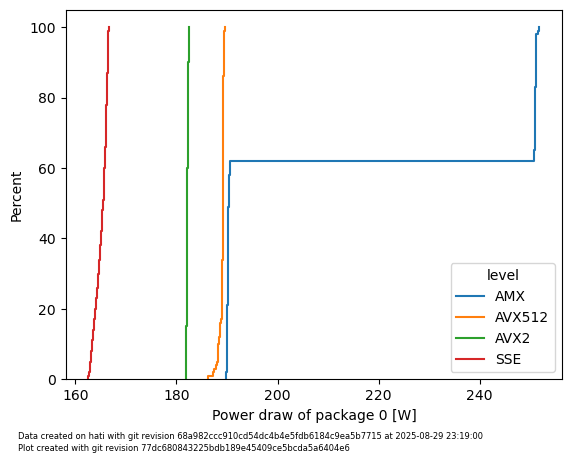

In [ ]:
ax = sns.ecdfplot(data=all_data_pivot[POWER_WATT].reset_index(), x=POWER_WATT, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'package-power-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)

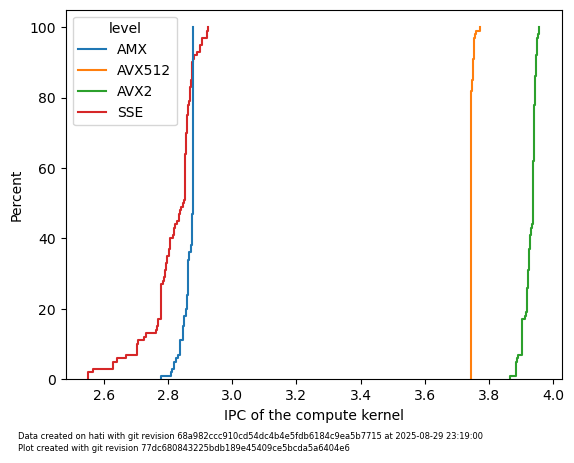

In [ ]:
ax = sns.ecdfplot(data=all_data_pivot[PERF_IPC].reset_index(), x=PERF_IPC, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'perf-ipc-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)

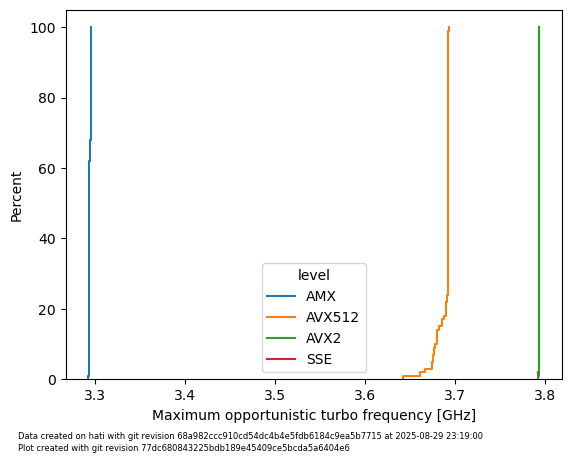

In [ ]:
ax = sns.ecdfplot(data=all_data_pivot[MAX_TURBO_FREQ].reset_index(), x=MAX_TURBO_FREQ, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'perf-freq-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)

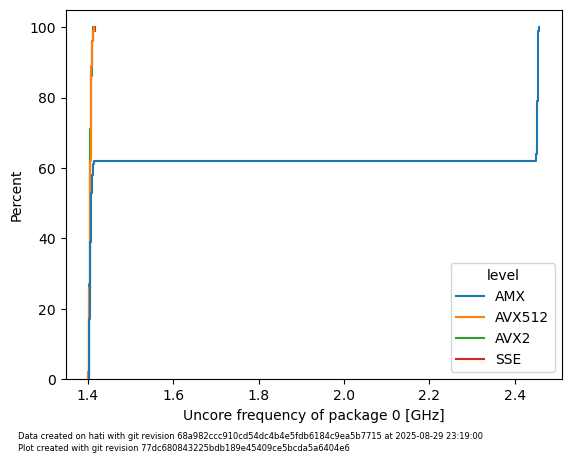

In [ ]:
ax = sns.ecdfplot(data=all_data_pivot[UNCORE_FREQ].reset_index(), x=UNCORE_FREQ, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'uncore-freq-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)

In [36]:
df_performance_deviation = all_data_pivot[PERFORMANCE].reset_index()

for key, value in df_performance_deviation.groupby("level"):
    mean = value[PERFORMANCE].mean()
    df_performance_deviation.loc[value.index, [PERFORMANCE_DEVIATION]] = (value[PERFORMANCE] / mean - 1) * 100

print(df_performance_deviation)

     index   level  Performance [G Instructions/s]  \
0        0     AMX                        9.472734   
1        0    AVX2                       14.907904   
2        0  AVX512                       13.809957   
3        0     SSE                       10.676053   
4        1     AMX                        9.474103   
..     ...     ...                             ...   
395     98     SSE                       10.875433   
396     99     AMX                        9.473437   
397     99    AVX2                       14.949390   
398     99  AVX512                       13.822644   
399     99     SSE                       10.537661   

     Deviation from mean performance [%]  
0                               0.355385  
1                               0.016400  
2                              -0.055980  
3                              -0.013270  
4                               0.369885  
..                                   ...  
395                             1.854023  
396    

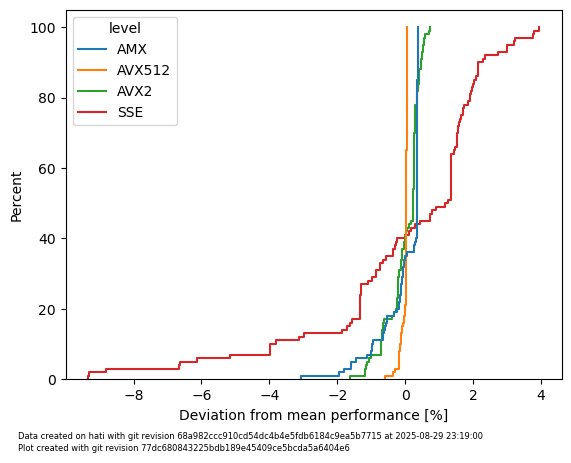

In [ ]:
ax = sns.ecdfplot(data=df_performance_deviation, x=PERFORMANCE_DEVIATION, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'performance-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)

In [38]:
df_energy_efficiency_deviation = all_data_pivot.reset_index()

for key, value in df_energy_efficiency_deviation.groupby("level"):
    max = value[ENERGY_EFFICIENCY].max()
    df_energy_efficiency_deviation.loc[value.index, [ENERGY_EFFICIENCY_DEVIATION]] = (value[ENERGY_EFFICIENCY] / max - 1)  * 100

print(df_energy_efficiency_deviation)

metric  index   level  IPC of the compute kernel  \
0           0     AMX                    2.87661   
1           0    AVX2                    3.93058   
2           0  AVX512                    3.74738   
3           0     SSE                    2.81491   
4           1     AMX                    2.87665   
..        ...     ...                        ...   
395        98     SSE                    2.86689   
396        99     AMX                    2.87664   
397        99    AVX2                    3.94077   
398        99  AVX512                    3.74361   
399        99     SSE                    2.77752   

metric  Maximum opportunistic turbo frequency [GHz]  \
0                                           3.29302   
1                                           3.79280   
2                                           3.68523   
3                                           3.79268   
4                                           3.29345   
..                                           

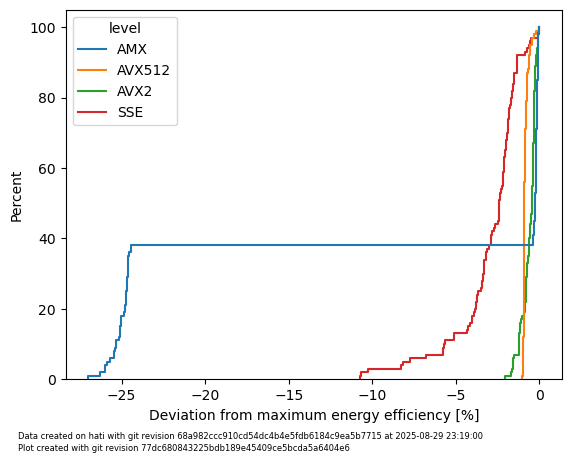

In [ ]:
ax = sns.ecdfplot(data=df_energy_efficiency_deviation, x=ENERGY_EFFICIENCY_DEVIATION, hue='level', hue_order=hue_order, stat='percent')
ax.set_ylim(0, 100)
Plotting.savefig(experiment, 'energy-efficiency-ecdf.pdf', annotations_x_offset=0.05, annotations_y_offset=0, annotations_y_spacing=0.025)